# Celltype annotation transfer in multi-omics

In the field of multi-omics research, transferring cell type annotations from one data modality to another is a crucial step. For instance, when annotating cell types in single-cell ATAC sequencing (scATAC-seq) data, it's often desirable to leverage the cell type labels already annotated in single-cell RNA sequencing (scRNA-seq) data. This process involves integrating information from both scRNA-seq and scATAC-seq data modalities.

GLUE is a prominent algorithm used for cross-modality integration, allowing researchers to combine data from different omics modalities effectively. However, GLUE does not inherently provide a method for transferring cell type labels from scRNA-seq to scATAC-seq data. To address this limitation, an approach was implemented in the omicverse platform using K-nearest neighbor (KNN) graphs.

The KNN graph-based approach likely involves constructing KNN graphs separately for scRNA-seq and scATAC-seq data. In these graphs, each cell is connected to its K nearest neighbors based on certain similarity metrics, which could be calculated using gene expression profiles in scRNA-seq and accessibility profiles in scATAC-seq. Once these graphs are constructed, the idea is to transfer the cell type labels from the scRNA-seq side to the scATAC-seq side by assigning labels to scATAC-seq cells based on the labels of their KNN neighbors in the scRNA-seq graph.

Colab_Reproducibility：https://colab.research.google.com/drive/1aIMmSgyIw-PGjJ65WvMgz4Ob3EtoK_UV?usp=sharing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
import matplotlib.pyplot as plt
import scanpy as sc

ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 10:32:24 CST


## Loading the data preprocessed with GLUE

Here, we use two output files from the GLUE cross-modal integration, and their common feature is that they both have the `obsm['X_glue']` layer. And the rna have been annotated.

In [3]:
# !wget -O atac-emb.h5ad https://figshare.com/ndownloader/files/41418660
# !wget -O rna-emb.h5ad https://figshare.com/ndownloader/files/41418663

In [4]:
rna=sc.read("data/analysis_lymph/rna-emb.h5ad")
atac=sc.read("data/analysis_lymph/atac-emb.h5ad")

We can visualize the intergrated effect of GLUE with UMAP

In [5]:
combined=sc.concat([rna,atac],merge='same')
combined

AnnData object with n_obs × n_vars = 18380 × 0
    obs: 'domain', 'cell_type', 'balancing_weight'
    var: 'chromStart', 'chromEnd', 'highly_variable'
    obsm: 'X_glue', 'X_umap'
    varm: 'X_glue'

In [6]:
combined.obsm['X_mde']=ov.utils.mde(combined.obsm['X_glue'])

We can see that the two layers are correctly aligned

<Axes: title={'center': 'Layers'}, xlabel='X_mde1', ylabel='X_mde2'>

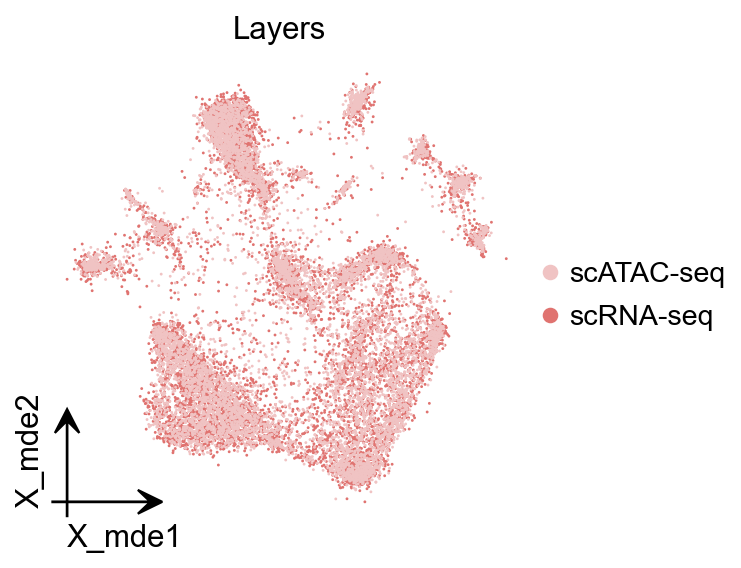

In [7]:
ov.utils.embedding(combined,
               basis='X_mde',
               color='domain',
                title='Layers',
                show=False,
                palette=ov.utils.red_color,
                frameon='small'
               )

And the RNA modality has an already annotated cell type label on it

<Axes: title={'center': 'Cell type'}, xlabel='X_mde1', ylabel='X_mde2'>

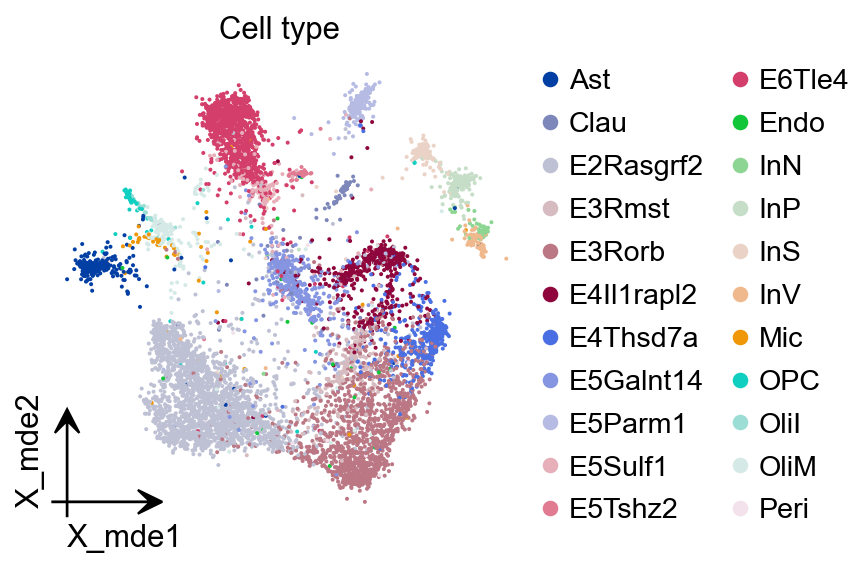

In [8]:
rna.obsm['X_mde']=combined.obsm['X_mde'][combined.obs['domain']=='scRNA-seq']
ov.utils.embedding(rna,
               basis='X_mde',
               color='cell_type',
                title='Cell type',
                show=False,
                #palette=ov.utils.red_color,
                frameon='small'
               )

## Celltype transfer

We train a knn nearest neighbour classifier using `X_glue` features

In [9]:
knn_transformer=ov.utils.weighted_knn_trainer(
    train_adata=rna,
    train_adata_emb='X_glue',
    n_neighbors=15,
)

Weighted KNN with n_neighbors = 15 ... 

In [10]:
labels,uncert=ov.utils.weighted_knn_transfer(
    query_adata=atac,
    query_adata_emb='X_glue',
    label_keys='cell_type',
    knn_model=knn_transformer,
    ref_adata_obs=rna.obs,
)

finished!


We migrate the training results of the KNN classifier to atac. `unc` stands for uncertainty, with higher uncertainty demonstrating lower migration accuracy, suggesting that the cell in question may be a double-fate signature or some other type of cell.

In [11]:
atac.obs["transf_celltype"]=labels.loc[atac.obs.index,"cell_type"]
atac.obs["transf_celltype_unc"]=uncert.loc[atac.obs.index,"cell_type"]

In [12]:
atac.obs["major_celltype"]=atac.obs["transf_celltype"].copy()

[<Axes: title={'center': 'transf_celltype_unc'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'transf_celltype'}, xlabel='X_umap1', ylabel='X_umap2'>]

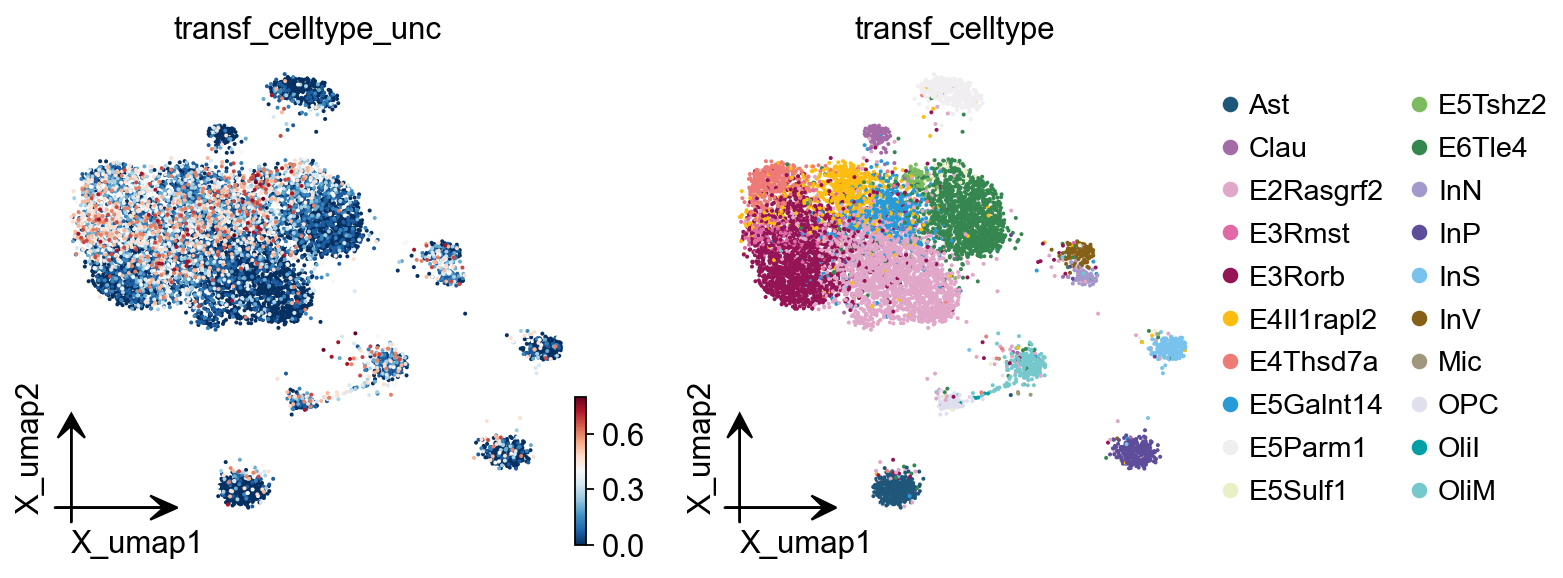

In [13]:
ov.utils.embedding(atac,
               basis='X_umap',
               color=['transf_celltype_unc','transf_celltype'],
                #title='Cell type Un',
                show=False,
                # palette=ov.palette()[11:],
                frameon='small'
               )

## Visualization

We can merge atac and rna after migration annotation and observe on the umap plot whether the cell types are consistent after merging the modalities.

In [14]:
import scanpy as sc
combined1=sc.concat([rna,atac],merge='same')
combined1

AnnData object with n_obs × n_vars = 18380 × 0
    obs: 'domain', 'cell_type', 'balancing_weight'
    var: 'chromStart', 'chromEnd', 'highly_variable'
    obsm: 'X_glue', 'X_umap'
    varm: 'X_glue'

In [15]:
combined1.obsm['X_mde']=ov.utils.mde(combined1.obsm['X_glue'])

We found that the annotation was better, suggesting that the KNN nearest-neighbour classifier we constructed can effectively migrate cell type labels from RNA to ATAC.

[<Axes: title={'center': 'Layers'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <Axes: title={'center': 'Cell type'}, xlabel='X_mde1', ylabel='X_mde2'>]

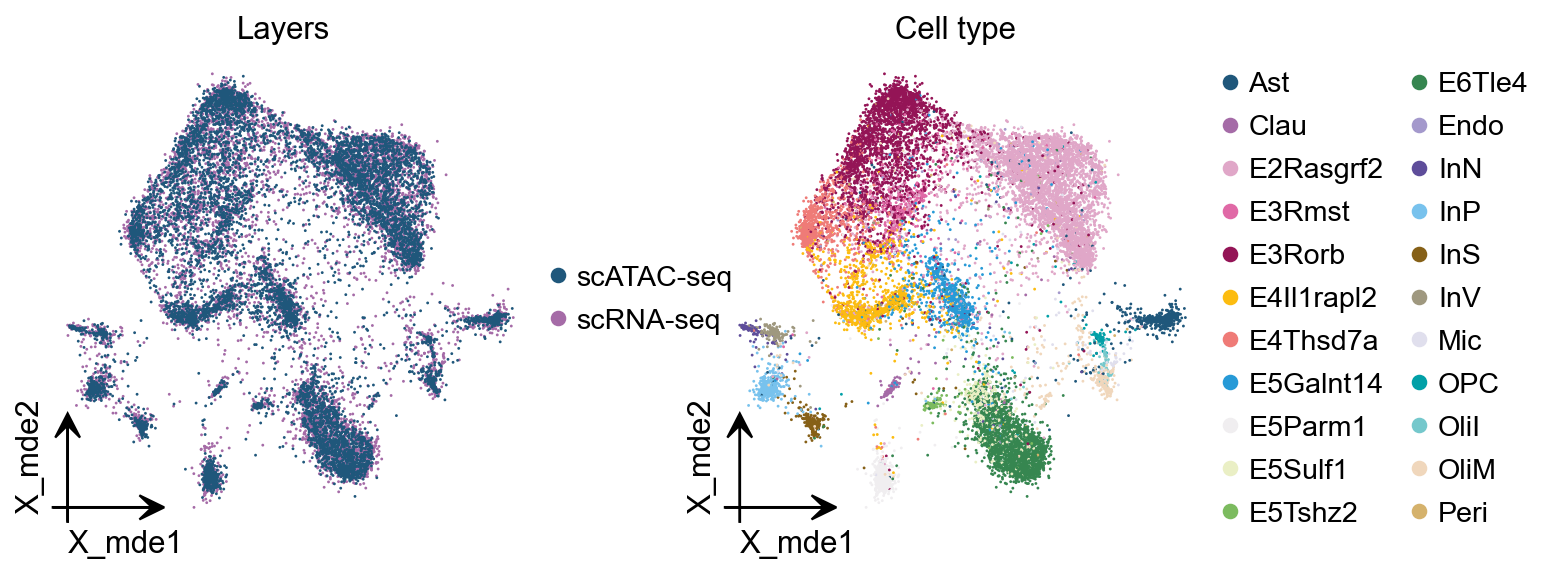

In [16]:
ov.utils.embedding(combined1,
               basis='X_mde',
               color=['domain','cell_type'],
                title=['Layers','Cell type'],
                show=False,
                # palette=ov.palette()[11:],
                frameon='small'
               )